# Setup

In [1]:
import seaborn as sns
import os
import json
from haversine import haversine
from pqdm.processes import pqdm
# from clustering import MeanShift
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

ms_radius = 200 # bandwidth radius for MeanShift clustering (in meters)
pre_min_pings = 5 # min pings per user in the before (pre) period
post_min_pings = 5 # "" in the after period per night

# MeanShift clustering parameters
ms_params = {'bin_seeding': True, 'min_bin_freq': 5, 'max_iter': 30, 'cluster_all': False}

# Visualization

# Visualization Distance

In [2]:
pre_home = pd.read_parquet(P.data + "/Ida_home.parquet")
post_home = pd.read_parquet(P.data + "/Ida_dist.parquet")
merged_home = pd.read_parquet(P.data + "/disp_by_uid.parquet")

pre_post_home = pd.merge(pre_home, post_home, on='uid')
# pre_post_home['dist'] = pre_post_home.apply(lambda row: haversine((row['lat_x'], row['lon_x']), (row['lat_y'], row['lon_y'])), axis = 1)
merged_home = pd.merge(merged_home, pre_post_home, on = 'uid')

merged_home['disp_wave1'] = (merged_home['disp_t']>=22*2) & (merged_home['disp_t']<29*2)
merged_home['disp_wave2'] = (merged_home['disp_t']>=29*2) & (merged_home['disp_t']<40*2) # wave2
merged_home['disp_wave3'] = (merged_home['disp_t']>=40*2) & (merged_home['disp_t']<50*2) # wave3

merged_home['disp_wave0'] = merged_home['disp_wave1'] | merged_home['disp_wave2'] | merged_home['disp_wave3']

merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg').to_crs(CRS_DEG)

merged_home = gpd.GeoDataFrame(
    merged_home, geometry=gpd.points_from_xy(merged_home.lon, merged_home.lat), crs=CRS_DEG)

merged_home = gpd.sjoin(merged_home, merged_tract, predicate = 'within')

merged_home = pd.merge(merged_home,  pd.read_parquet(P.data+"/repres_by_merged_tract.parquet"), on= 'id')

In [3]:
storm_line = gpd.read_file(P.data + '/hurricane/ida_path/line').to_crs(CRS_M)
storm_pts = gpd.read_file(P.data + '/hurricane/ida_path/points').to_crs(CRS_M)
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')

xmin, ymin, xmax, ymax = merged_home.to_crs(CRS_M).total_bounds

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 0 average evacuation distance: 29.45 mi


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 1 average evacuation distance: 34.33 mi


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 2 average evacuation distance: 30.80 mi


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 3 average evacuation distance: 19.91 mi


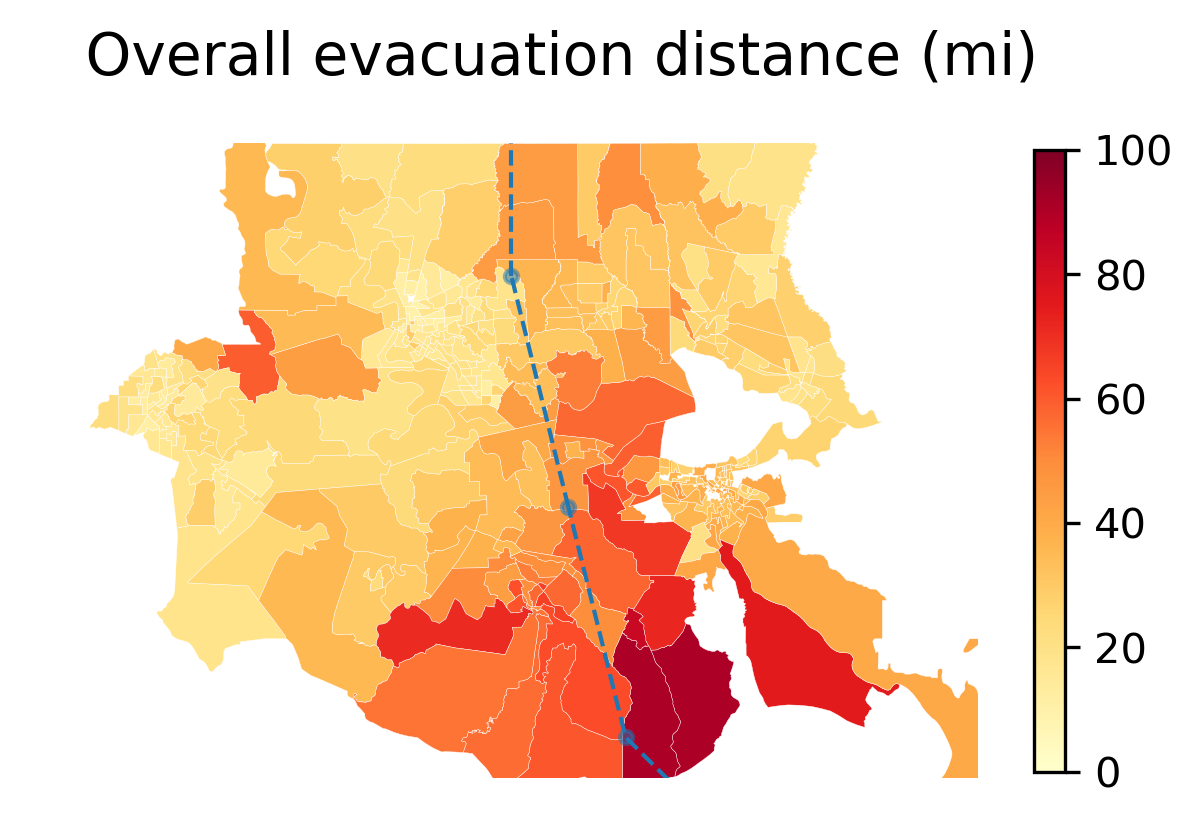

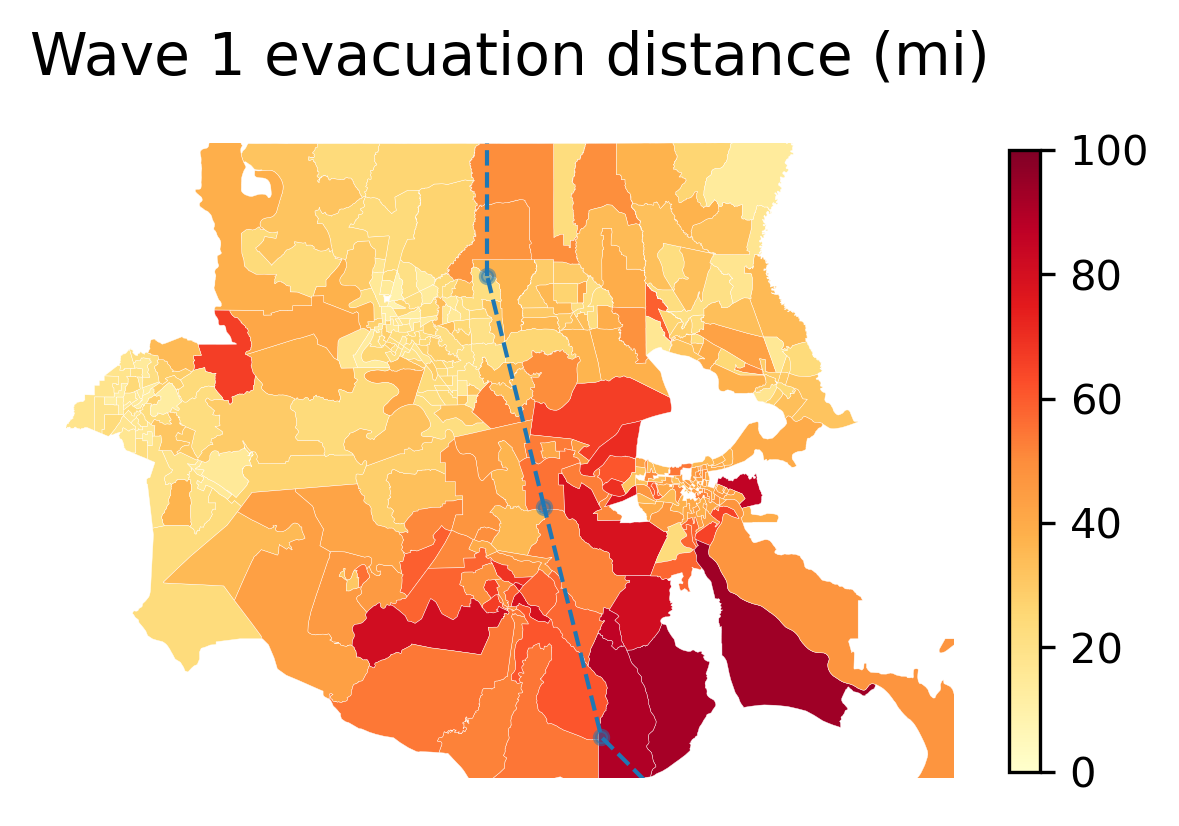

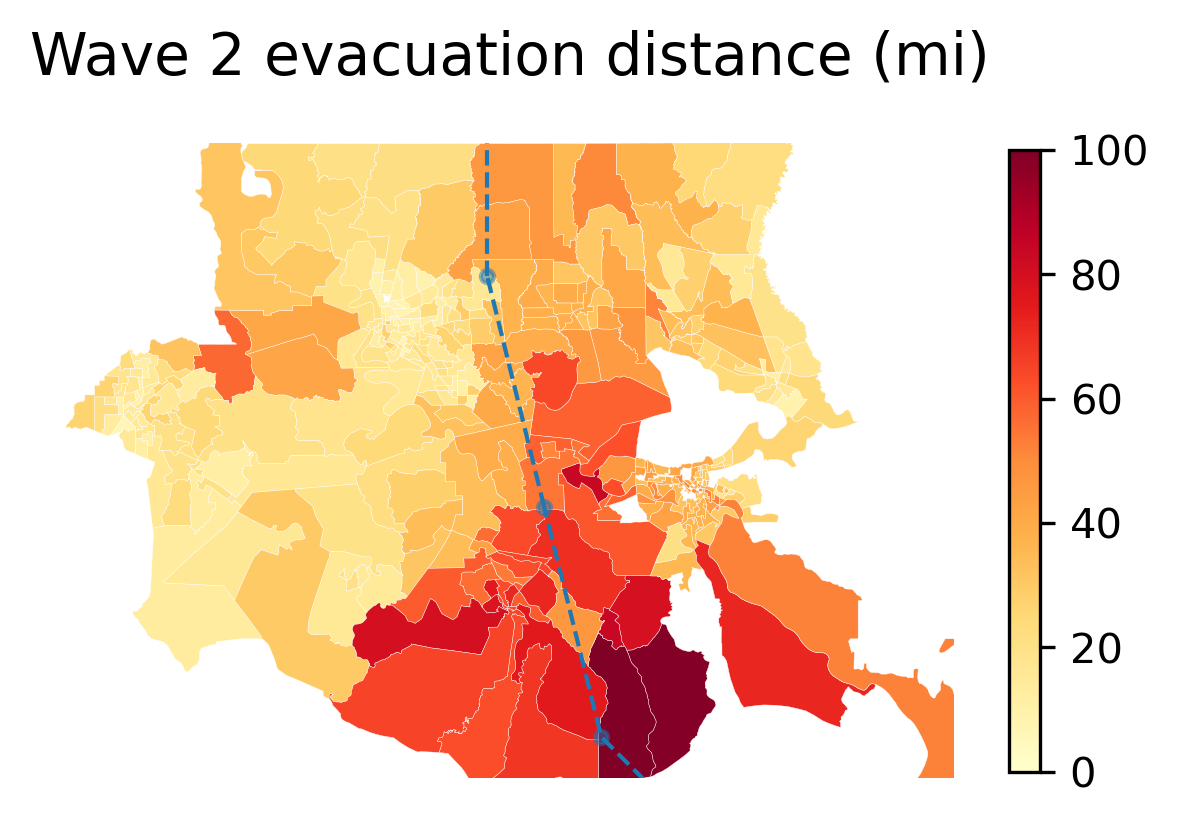

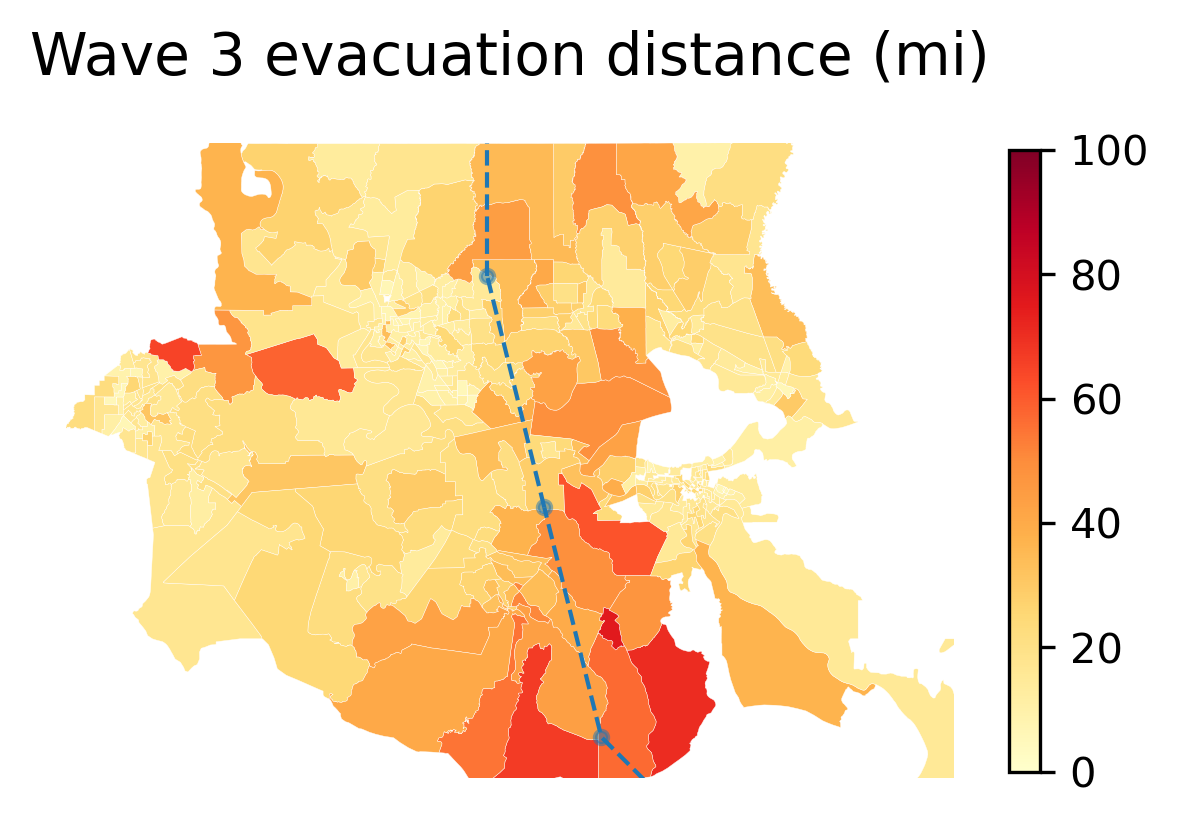

In [4]:
for i in range(0,4):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.axis("off")
    # plt.title(f'Wave{i} evacuation distance (km)')

    merged_home_agg = merged_home.loc[merged_home[f'disp_wave{i}']].groupby(['id','repres'])['dist'].mean().reset_index()
    
    merged_home_agg.columns = ['id', 'repres', 'dist']
    merged_home_agg= pd.merge(merged_tract, merged_home_agg, on = 'id')
    merged_home_agg['dist'] = merged_home_agg['dist']

    if i == 0:
        merged_home_agg.to_crs(CRS_M).plot(
            ax=ax, column='dist', cmap='YlOrRd', legend=True, 
            vmin=0, vmax=100, linewidth=0.1, edgecolor='white',
            legend_kwds={'shrink':0.8})#, 'label':'Evacuation distance (mi)'})
    else:
        merged_home_agg.to_crs(CRS_M).plot(
            ax=ax, column='dist', cmap='YlOrRd', legend=True, 
            vmin=0, vmax=100, linewidth=0.1, edgecolor='white',
            legend_kwds={'shrink':0.8})#, 'label':'Evacuation distance (mi)'})

    storm_line.plot(ax=ax, ls = '--', color='C0', linewidth=1)
    storm_pts.plot(ax=ax, markersize=10, color='C0', alpha=0.5)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    # ax.text(x = 0.7*(xmax-xmin) + xmin, y = 0.8*(ymax-ymin) + ymin, s = f"Avg. evacuation\ndistance: {merged_home.loc[merged_home[f'disp_wave{i}']]['dist'].mean()/1.60934:.2f} mi") # show evacuation rate in the plot
    print(f"Wave {i} average evacuation distance: {merged_home.loc[merged_home[f'disp_wave{i}']]['dist'].mean():.2f} mi") # show evacuation rate in the plot
    
    if i == 0:
        plt.title(f'   Overall evacuation distance (mi)', fontsize = 14)
    else:
        plt.title(f'Wave {i} evacuation distance (mi)', fontsize= 14)
    
    plt.tight_layout()

    plt.savefig(f'../figs/wave{i}_distance.pdf')
    plt.savefig(f'../figs/wave{i}_distance.png', dpi=300)

# Visualize duration

In [7]:
pre_home = pd.read_parquet(P.data + "/Ida_home.parquet")
merged_home = pd.read_parquet(P.data + "/disp_by_uid.parquet")

pre_post_home = pd.merge(pre_home, post_home, on='uid')
merged_home = pd.merge(merged_home, pre_post_home, on = 'uid')

storm_line = gpd.read_file(P.data + '/hurricane/ida_path/line').to_crs(CRS_M)
storm_pts = gpd.read_file(P.data + '/hurricane/ida_path/points').to_crs(CRS_M)

merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg').to_crs(CRS_DEG)

merged_home = gpd.GeoDataFrame(
    merged_home, geometry=gpd.points_from_xy(merged_home.lon, merged_home.lat), crs=CRS_DEG)
merged_home = gpd.sjoin(merged_home, merged_tract, op = 'within')

merged_home = merged_home[merged_home['returned_t']!=-1]

merged_home['disp_wave1'] = (merged_home['disp_t']>=22*2) & (merged_home['disp_t']<29*2)
merged_home['disp_wave2'] = (merged_home['disp_t']>=29*2) & (merged_home['disp_t']<40*2) # wave2
merged_home['disp_wave3'] = (merged_home['disp_t']>=40*2) & (merged_home['disp_t']<50*2) # wave3
merged_home['disp_wave0'] = merged_home['disp_wave1'] | merged_home['disp_wave2'] | merged_home['disp_wave3']

merged_home = pd.merge(merged_home,  pd.read_parquet(P.data+"/repres_by_merged_tract.parquet"), on= 'id')

xmin, ymin, xmax, ymax = merged_home.to_crs(CRS_M).total_bounds

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 0 average evacuation cycle duration: 9.07 days


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 1 average evacuation cycle duration: 10.58 days


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 2 average evacuation cycle duration: 9.16 days


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Wave 3 average evacuation cycle duration: 6.81 days


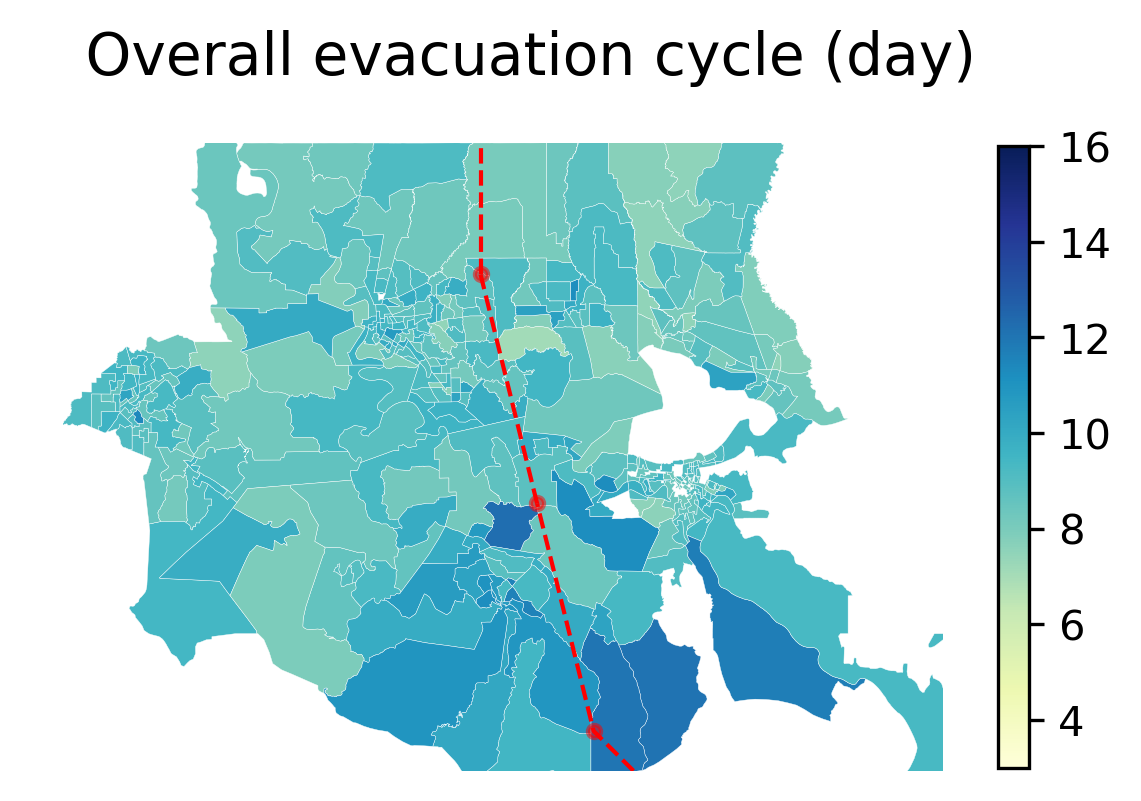

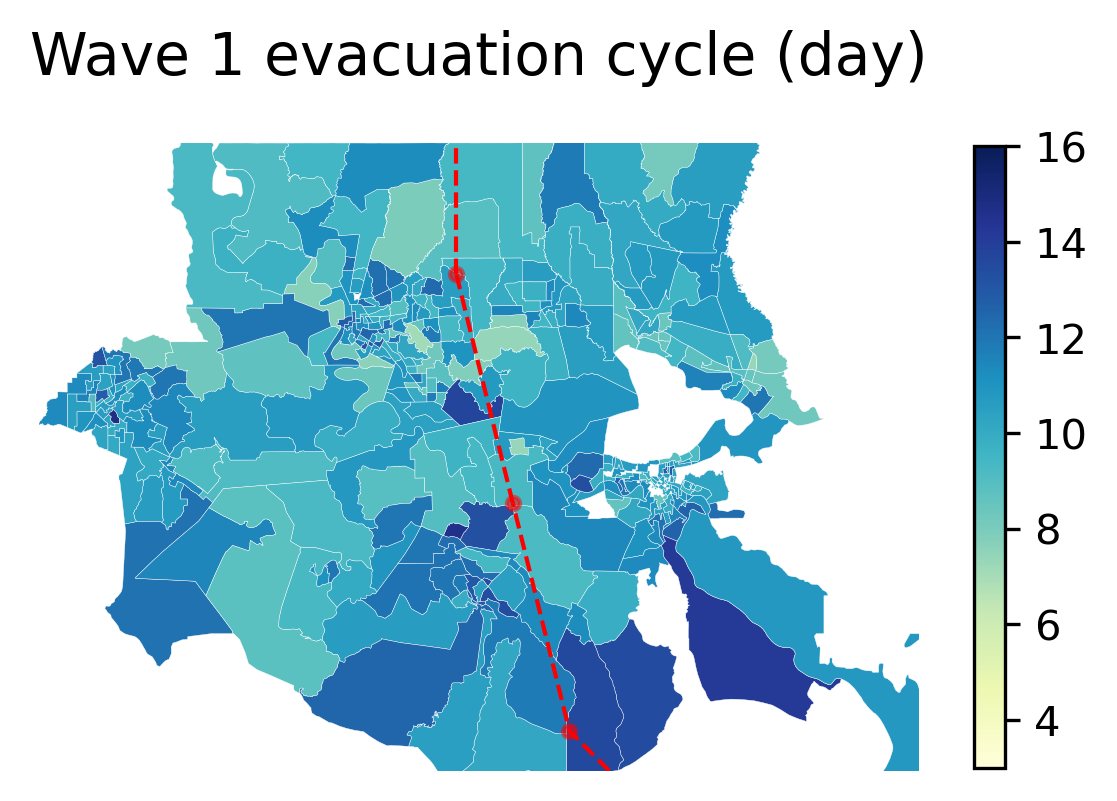

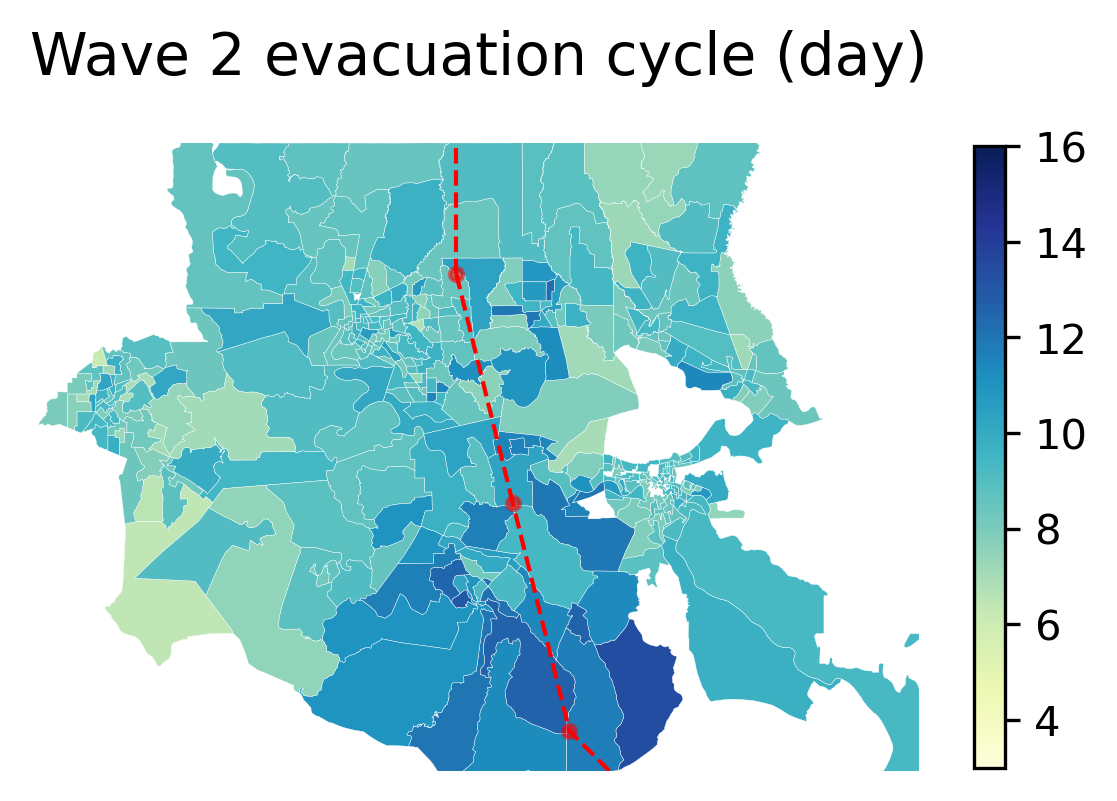

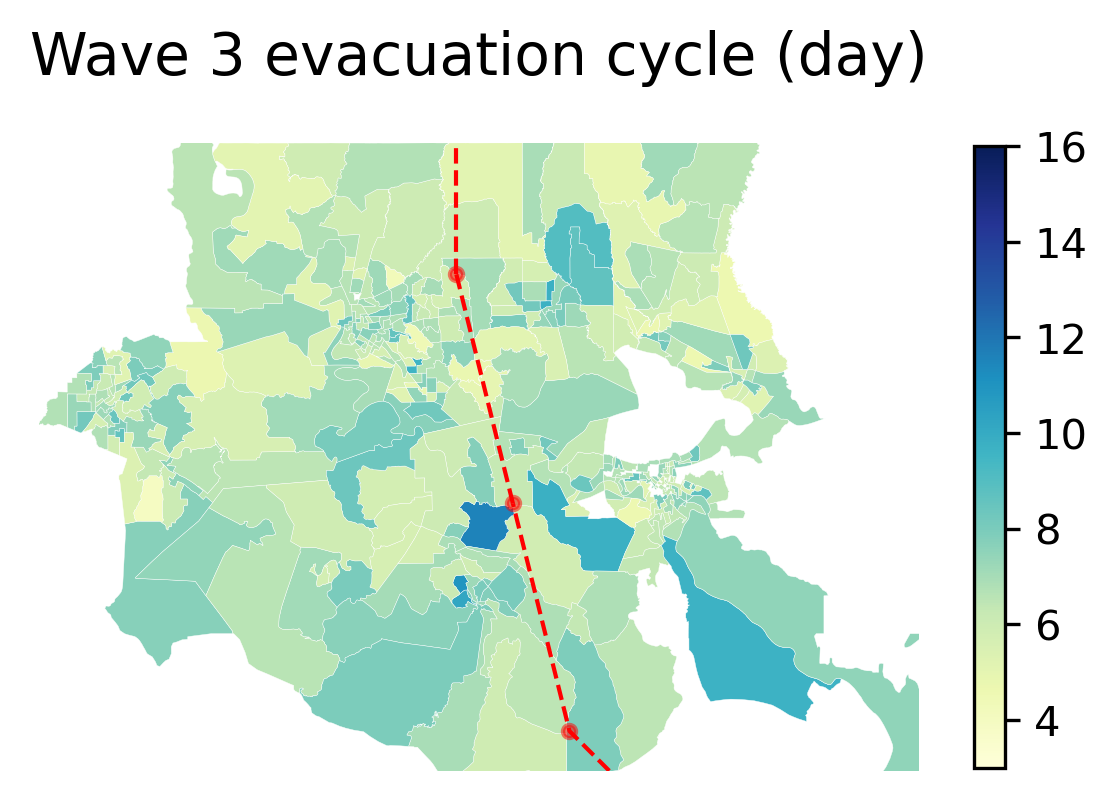

In [8]:
for i in range(0,4):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.axis("off")
    # plt.title(f'Wave{i} evacuation cycle duration')

    merged_home_agg = merged_home.loc[merged_home[f'disp_wave{i}']].groupby(['id', 'repres'])['duration'].mean().reset_index()
    merged_home_agg.columns = ['id', 'repres', 'duration']
    merged_home_agg['duration'] = merged_home_agg['duration']/2
    merged_home_agg = pd.merge(merged_tract, merged_home_agg, on = 'id')
    if i == 0:
        merged_home_agg.to_crs(CRS_M).plot(
            ax=ax, column='duration', cmap='YlGnBu', legend=True, 
            vmin=3, vmax=16, linewidth=0.1, edgecolor='white',
            legend_kwds={'shrink':0.8})#, 'label':'Evacuation cycle duration (day)'})
    else:
        merged_home_agg.to_crs(CRS_M).plot(
            ax=ax, column='duration', cmap='YlGnBu', legend=True, 
            vmin=3, vmax=16, linewidth=0.1, edgecolor='white',
            legend_kwds={'shrink':0.8})#, 'label':'Evacuation cycle duration (day)'})

    storm_line.plot(ax=ax, ls = '--', color='r', linewidth=1)
    storm_pts.plot(ax=ax, markersize=10, color='r', alpha=0.5)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    if i == 0:
        plt.title(f'   Overall evacuation cycle (day)', fontsize=14)
    else:
        plt.title(f'Wave {i} evacuation cycle (day)', fontsize=14)

    # ax.text(x = 0.7*(xmax-xmin) + xmin, y = 0.8*(ymax-ymin) + ymin, s = f"Avg. evacuation\ncycle duration: {merged_home.loc[merged_home[f'disp_wave{i}']]['duration'].mean()/2:.2f} days") # show evacuation rate in the plot
    print(f"Wave {i} average evacuation cycle duration: {merged_home.loc[merged_home[f'disp_wave{i}']]['duration'].mean()/2:.2f} days") # show evacuation rate in the plot
    plt.tight_layout()

    plt.savefig(f'../figs/wave{i}_duration.pdf')
    plt.savefig(f'../figs/wave{i}_duration.png', dpi=300)

In [8]:
# fig, ax = plt.subplots(figsize=(2, 5), dpi=120)
# plt.axis("off")
# merged_home_agg.to_crs(CRS_M).plot(
#     ax=ax, column='duration', cmap='RdYlBu', legend=True, 
#     vmin=0, vmax=14, linewidth=0, edgecolor='white', alpha = 0,
#     legend_kwds={'shrink':0.5, 'label':'Evacuation cycle duration (day)'})

# # storm_line.plot(ax=ax, color='r', linewidth=0.5)
# # storm_pts.plot(ax=ax, markersize=5, color='r', alpha=0.5)

# colorbar = ax.get_figure().get_axes()[1]
# colorbar.set_yticks([0,2,4,6,8,10,12,14])
# colorbar.set_yticklabels(['0','2','4','6','8', '10', '12','>=14'])

# # ax.set_xlim([xmin,xmax])
# # ax.set_ylim([ymin,ymax])
# plt.tight_layout()

# plt.savefig('../figs/legend_duration.pdf')
# plt.savefig('../figs/legend_duration.png', dpi=300)